# 연관규칙 분석(Association Rule Analysis)

* 정의 : 어떤 두 아이템 집합이 번번히 발생하는가를 알려주는 일련의 규칙들을 생성하는 알고리즘
* 항목(item)들 관계를 if-then 형식으로 찾아가는 분석 방법
* 거래(transaction)와 항목(item)으로 구성되어 있는 경우 분석이 가능


In [2]:
from IPython.display import Image # 주피터 노트북에 이미지 삽입시 쓰는 라이브러리

<img src="./1-1. 변수설명.png">

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# 데이터 불러오기

path = "./lotto.csv"
df = pd.read_csv(path)
df.head()

,time_id,num1,num2,num3,num4,num5,num6
0,859,8,22,35,38,39,41
1,858,9,13,32,38,39,43
2,857,6,10,16,28,34,38
3,856,10,24,40,41,43,44
4,855,8,15,17,19,43,44


In [11]:
# 데이터 정보 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 7 columns):
time_id    859 non-null int64
num1       859 non-null int64
num2       859 non-null int64
num3       859 non-null int64
num4       859 non-null int64
num5       859 non-null int64
num6       859 non-null int64
dtypes: int64(7)
memory usage: 47.1 KB


In [12]:
# 데이터 요약통계량 확인

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time_id,859.0,430.000000,248.116236,1.0,215.5,430.0,644.5,859.0
num1,859.0,6.641444,5.247440,1.0,2.5,5.0,10.0,35.0
num2,859.0,13.012806,6.819421,2.0,8.0,12.0,17.0,37.0
num3,859.0,19.863795,7.487602,3.0,14.0,19.0,25.0,40.0
num4,859.0,26.183935,7.643952,5.0,21.0,27.0,32.0,43.0
num5,859.0,32.844005,6.889834,9.0,28.0,34.0,38.0,44.0
num6,859.0,39.478463,5.345668,19.0,37.0,41.0,44.0,45.0


In [13]:
# 칼럼별 결측값 개수 구하기

df.isnull().sum()  # 변수 7개 모두 결측치는 없다.

time_id    0
num1       0
num2       0
num3       0
num4       0
num5       0
num6       0
dtype: int64

### 1. 연관규칙분석을 수행하기 위해 lotto 데이터셋을 transaction 데이터로 변환하시오.
### (단, 본 분석에서 로또번호가 추첨된 순서는 고려하지 않고 분석을 수행하도록 한다.) 
### 그리고 변환된 데이터에서 가장 많이 등장한 상위 10개의 로또번호를 막대그래프로 출력하고 이에 대해 설명하시오.

#### 1-1) lotto -> transaction 데이터로 변환
#### 1-2) 변환된 데이터에서 가장 많이 등장한 상위 10개의 로또번호를 막대그래프로 출력

In [16]:
# 1-1) lotto -> transaction 데이터로 변환

df_t = df.iloc[:,1:] # 첫번째 칼럼(time_id)는 인덱스이므로 제외
ds = df_t.values # 데이터프레임의 값
ds

array([[ 8, 22, 35, 38, 39, 41],
       [ 9, 13, 32, 38, 39, 43],
       [ 6, 10, 16, 28, 34, 38],
       ...,
       [11, 16, 19, 21, 27, 31],
       [ 9, 13, 21, 25, 32, 42],
       [10, 23, 29, 33, 37, 40]], dtype=int64)

In [18]:
# apriori용 데이터셋 변형

transactions = []

for i in range(ds.shape[0]):
    transactions.append([str(ds[i][j]) for j in range(ds.shape[1])])

[참고 : apriori용 데이터셋 변형](https://wikidocs.net/44413) 

In [19]:
transactions

[['8', '22', '35', '38', '39', '41'],
 ['9', '13', '32', '38', '39', '43'],
 ['6', '10', '16', '28', '34', '38'],
 ['10', '24', '40', '41', '43', '44'],
 ['8', '15', '17', '19', '43', '44'],
 ['20', '25', '31', '32', '36', '43'],
 ['2', '8', '23', '26', '27', '44'],
 ['11', '17', '28', '30', '33', '35'],
 ['14', '18', '22', '26', '31', '44'],
 ['16', '20', '24', '28', '36', '39'],
 ['5', '13', '17', '29', '34', '39'],
 ['1', '2', '16', '22', '38', '39'],
 ['12', '16', '26', '28', '30', '42'],
 ['5', '18', '30', '41', '43', '45'],
 ['1', '16', '29', '33', '40', '45'],
 ['7', '8', '13', '15', '33', '45'],
 ['19', '21', '30', '33', '34', '42'],
 ['14', '26', '32', '36', '39', '42'],
 ['5', '11', '14', '30', '33', '38'],
 ['2', '4', '11', '28', '29', '43'],
 ['3', '9', '11', '12', '13', '19'],
 ['9', '14', '17', '33', '36', '38'],
 ['2', '25', '28', '30', '33', '45'],
 ['1', '9', '11', '14', '26', '28'],
 ['9', '10', '13', '28', '38', '45'],
 ['6', '8', '18', '35', '42', '43'],
 ['12', '18

In [34]:
# apriori 알고리즘을 파이썬 코드로 구현한 패키지

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


# TransactionEncoder 
# : 데이터셋의 고유 레이블을 학습하고 transform 메소드를 통해 리스트 형식의 데이터셋을 원핫인코딩된 boolean 배열로 변형

te = TransactionEncoder()
te_result = te.fit(transactions).transform(transactions)
te_result 

array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False,  True, False, ..., False, False, False]])

[참고 : 연관성분석 조건설정](https://wotres.tistory.com/entry/Association-Rule-%EC%97%B0%EA%B4%80%EC%84%B1-%EB%B6%84%EC%84%9D-in-python)


[참고 : mlxtend 라이브러리](https://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/)

In [21]:
# 편의를 위해 데이터프레임 형식으로 변환

df_apriori = pd.DataFrame(te_result, columns=te.columns_)  
# te.columns_ : 유니크한(중복이 안되는) 칼럼 명 

df_apriori.head(20) 

,1,10,11,12,13,14,15,16,17,18,...,41,42,43,44,45,5,6,7,8,9
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,True,False,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,True,False,...,False,False,True,True,False,False,False,False,True,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
7,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
9,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
# 1-2) 변환된 데이터에서 가장 많이 등장한 상위 10개의 로또번호를 막대그래프로 출력

df_top = pd.DataFrame(df_apriori.sum().sort_values(ascending = False), columns = ["count"])
# df.sum().sort_values(ascending = False) : df의 합계를 내림차순

df_top.head(10)

,count
34,134
27,126
40,126
43,125
20,124
12,123
17,123
14,122
13,122
1,122


In [24]:
top10 = df_top["count"][:10]
top10

34    134
27    126
40    126
43    125
20    124
12    123
17    123
14    122
13    122
1     122
Name: count, dtype: int64

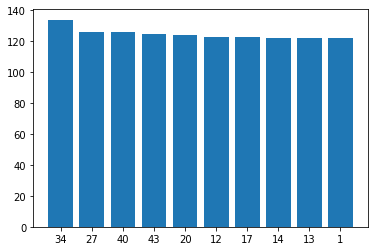

In [25]:
# 상위 top10 막대 그래프 그리기

x = np.arange(10)
plt.bar(x, top10.values)
plt.xticks(x, top10.index)
plt.show()

In [26]:
# 결론
# 상위 10 번호는 (34,27,40,43,20,12,17,14,13,1) 번호이며
# 34번호가 134회로 가장 많이 추첨되었다.

### 2. 변환한 데이터에 대해 apriori함수를 사용하여 다음 괄호 안의 조건을 반영하여 연관규칙을 생성하고, 이를 'rules_1'이라는 변수에 저장하여 결과를 해석하시오
### (최소 지지도: 0.002, 최소 신뢰도: 0.8, 최소조합 항목수: 2개, 최대조합 항목 수 :6개)
### 그리고 도출된 연관규칙들을 향상도를 기준으로 내림차순 정렬하여 상위 30개의 규칙을 확인하고, 이를 데이터프레임으로 변환하여 csv파일로 출력하시오.

#### 2-1) 변환된 데이터에 apriori 함수 사용하여 괄호안의 조건 반영하여 연관 규칙 생성
####     (최소지지도 : 0.002, 최소신뢰도 : 0.8, 최소조합 항목수 : 2, 최대조합 항목수 : 6)
#### 2-2) 이를 rules_1 변수에 저장하고 결과 해석
#### 2-3) 도출된 연관규칙들을 향상도를 기준으로 내림차순 정렬하여 상위 30개의 규칙을 확인하고, 
#### 2-4) 이를 데이터프레임으로 전환하여 csv 파일로 출력

In [27]:
# apriori 훈련하기
# 2-1) 최소지지도 : 0.002, 최소신뢰도 : 0.8, 최소조합 항목수 : 2, 최대조합 항목수 : 6)

# 최소 지지도 0.002
frequent_itemsets = apriori(df_apriori, min_support = 0.002, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.142026,(1)
1,0.142026,(10)
2,0.139697,(11)
3,0.143190,(12)
4,0.142026,(13)
5,0.142026,(14)
6,0.135041,(15)
7,0.128056,(16)
8,0.143190,(17)
9,0.140861,(18)


In [29]:
# 최소조합 항목수 : 2, 최대조합 항목수 : 6(어차피 최대 6개이므로 생략)

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
frequent_itemsets[frequent_itemsets["length"]>=2]

,support,itemsets,length
45,0.020955,"(1, 10)",2
46,0.016298,"(11, 1)",2
47,0.023283,"(12, 1)",2
48,0.016298,"(13, 1)",2
49,0.012806,"(14, 1)",2
50,0.011641,"(15, 1)",2
51,0.018626,"(16, 1)",2
52,0.019790,"(17, 1)",2
53,0.017462,"(18, 1)",2
54,0.012806,"(19, 1)",2


In [30]:
# 최소 신뢰도 0.8

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(31, 1, 10)",(17),0.002328,0.143190,0.002328,1.0,6.983740,0.001995,inf
1,"(17, 1, 10)",(31),0.002328,0.137369,0.002328,1.0,7.279661,0.002008,inf
2,"(1, 20, 40)",(10),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf
3,"(10, 20, 40)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf
4,"(11, 26, 1)",(14),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf
5,"(11, 14, 1)",(26),0.002328,0.135041,0.002328,1.0,7.405172,0.002014,inf
6,"(14, 26, 1)",(11),0.002328,0.139697,0.002328,1.0,7.158333,0.002003,inf
7,"(11, 18, 5)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf
8,"(11, 5, 1)",(18),0.002328,0.140861,0.002328,1.0,7.099174,0.002000,inf
9,"(21, 11, 44)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf


In [31]:
# consequent(결과절, 조건절 뒷부분)가 하나일때

rules["consequents_len"]=rules["consequents"].apply(lambda x : len(x))
rules["antecedents_len"]=rules["antecedents"].apply(lambda x : len(x))
rules_1 = rules[rules["consequents_len"]==1]
rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,consequents_len,antecedents_len
0,"(31, 1, 10)",(17),0.002328,0.143190,0.002328,1.0,6.983740,0.001995,inf,1,3
1,"(17, 1, 10)",(31),0.002328,0.137369,0.002328,1.0,7.279661,0.002008,inf,1,3
2,"(1, 20, 40)",(10),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,1,3
3,"(10, 20, 40)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,1,3
4,"(11, 26, 1)",(14),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,1,3
5,"(11, 14, 1)",(26),0.002328,0.135041,0.002328,1.0,7.405172,0.002014,inf,1,3
6,"(14, 26, 1)",(11),0.002328,0.139697,0.002328,1.0,7.158333,0.002003,inf,1,3
7,"(11, 18, 5)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,1,3
8,"(11, 5, 1)",(18),0.002328,0.140861,0.002328,1.0,7.099174,0.002000,inf,1,3
9,"(21, 11, 44)",(1),0.002328,0.142026,0.002328,1.0,7.040984,0.001998,inf,1,3


In [32]:
# antecedent : 조건절. "만약~라면"에 해당되는 부분
# consequent : 결과절, 조건절 뒷부분

rules_1["antecedents_len"].value_counts()  # 최소조합 2, 최대조합 6 조건 만족

3    632
4     47
Name: antecedents_len, dtype: int64

In [33]:
rules_1.describe().transpose()

C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,count,mean,std,min,25%,50%,75%,max
antecedent support,679.0,0.002364,0.000202,0.002328,0.002328,0.002328,0.002328,0.003492
consequent support,679.0,0.135245,0.009589,0.103609,0.130384,0.137369,0.142026,0.155995
support,679.0,0.002364,0.000202,0.002328,0.002328,0.002328,0.002328,0.003492
confidence,679.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lift,679.0,7.433846,0.566550,6.410448,7.040984,7.279661,7.669643,9.651685
leverage,679.0,0.002044,0.000174,0.001965,0.001998,0.002011,0.002027,0.003098
conviction,679.0,inf,NaN,inf,inf,NaN,inf,inf
consequents_len,679.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
antecedents_len,679.0,3.069219,0.254014,3.000000,3.000000,3.000000,3.000000,4.000000


[참고 : 연관분석 지표 설명](https://velog.io/@sossont/A-priori-Algorithm%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84-%EB%B6%84%EC%84%9D)

<img src="./1-1. 지표해석.png">

In [35]:
# 2-2) rules_1 변수에 저장하고 결과 해석


# 결론
# 최소지지도 0.002, 신뢰도 0.8, 최소조합 항목수 2개, 최대조합 항목수 6개로 설정하여 연관분석을 실시하였다.
# 총 679개의 연관규칙이 발견되었고, 
# 632개는 조건절에서 로또번호가 3개, 47개는 조건절에서 로또번호가 4개로 이루어져있다.     
# 향상도 최소값은 6.41이고, 최대값은 9.65이다
# 추첨번호들의 교집합 확률을 의미하는 지지도의 평균은 0.002364이다.


In [36]:
# 2-3) 향상도를 기준으로 내림차순 정렬하여 상위 30개의 규칙을 확인

rules_1 = rules_1.sort_values(by="lift", ascending = False).iloc[:30]
rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,consequents_len,antecedents_len
408,"(18, 23, 35)",(9),0.002328,0.103609,0.002328,1.0,9.651685,0.002087,inf,1,3
249,"(14, 17, 33)",(9),0.002328,0.103609,0.002328,1.0,9.651685,0.002087,inf,1,3
531,"(23, 7, 28)",(9),0.002328,0.103609,0.002328,1.0,9.651685,0.002087,inf,1,3
607,"(38, 43, 32)",(9),0.002328,0.103609,0.002328,1.0,9.651685,0.002087,inf,1,3
64,"(42, 27, 10)",(22),0.002328,0.107101,0.002328,1.0,9.336957,0.002079,inf,1,3
635,"(34, 36, 44, 10)",(22),0.002328,0.107101,0.002328,1.0,9.336957,0.002079,inf,1,4
506,"(31, 34, 7)",(22),0.002328,0.107101,0.002328,1.0,9.336957,0.002079,inf,1,3
502,"(45, 31, 25)",(22),0.002328,0.107101,0.002328,1.0,9.336957,0.002079,inf,1,3
500,"(36, 38, 24)",(22),0.002328,0.107101,0.002328,1.0,9.336957,0.002079,inf,1,3
497,"(31, 24, 7)",(22),0.002328,0.107101,0.002328,1.0,9.336957,0.002079,inf,1,3


In [269]:
# 이를 데이터프레임으로 변환하여 csv 파일로 출력

rules_1.to_csv("rules_1.csv")

### 3. 생성된 연관규칙 'rules_1'에 대한 정보를 해석하고, 1)번 문제를 통해 확인했을 때 가장 많이 추첨된 번호가 우측항에 존재하는 규칙들만을 ‘rules_most_freq’라는 변수에 저장하시오. 
### 그리고 해당 규칙들을 해석하여 인사이트를 도출한 후 서술하시오.

#### 3-1) rules_1에 대한 정보를 해석하고
#### 3-2) 1번 문제를 통해 확인했을때 가장 많이 추첨된 번호가 우측항에 존재하는 규칙들만을 'rules_most_freq'라는 변수에 저장하시오
#### 3-3) 해당 규칙들을 해석하여 인사이트를 도출한 후 서술하시오

In [37]:
# 3-1) rules_1(top30)에 대한 정보를 해석

rules_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
antecedent support,30.0,0.002367,0.000213,0.002328,0.002328,0.002328,0.002328,0.003492
consequent support,30.0,0.109934,0.004064,0.103609,0.107101,0.110012,0.112922,0.115250
support,30.0,0.002367,0.000213,0.002328,0.002328,0.002328,0.002328,0.003492
confidence,30.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lift,30.0,9.108460,0.338634,8.676768,8.855670,9.096313,9.336957,9.651685
leverage,30.0,0.002107,0.000187,0.002060,0.002065,0.002079,0.002079,0.003098
conviction,30.0,inf,NaN,inf,inf,inf,inf,inf
consequents_len,30.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
antecedents_len,30.0,3.066667,0.253708,3.000000,3.000000,3.000000,3.000000,4.000000


In [38]:
# antecedent : 조건절. "만약~라면"에 해당되는 부분
# consequent : 결과절, 조건절 뒷부분

rules_1["antecedents_len"].value_counts()

3    28
4     2
Name: antecedents_len, dtype: int64

In [39]:
rules_1["consequents"].value_counts()

(22)    11
(32)    10
(23)     5
(9)      4
Name: consequents, dtype: int64

In [40]:
# 결론
# 총 30개의 연관규칙이 발견되었고, 
# 28개는 조건절에서 로또번호가 3개, 4개는 조건절에서 로또번호가 4개로 이루어져있다.     
# 향상도 최소값은 8.67이고, 최대값은 9.65이다

In [41]:
# 3-2) 1번 문제를 통해 확인했을때 가장 많이 추첨된 번호가 우측항에 존재하는 규칙들만을 'rules_most_freq'라는 변수에 저장

rules["consequents"][0]  # 번호 표기양식확인

frozenset({'17'})

In [42]:
# 가장 많이 추첨된 번호 : 34

rules_most_freq = rules[rules["consequents"]=={'34'}]
rules_most_freq

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,consequents_len,antecedents_len
21,"(13, 5, 1)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
181,"(36, 12, 37)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
224,"(13, 29, 5)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
269,"(14, 25, 44)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
289,"(19, 15, 41)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
294,"(21, 2, 15)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
298,"(2, 28, 15)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
391,"(29, 17, 5)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3
395,"(17, 33, 32)",(34),0.003492,0.155995,0.003492,1.0,6.410448,0.002948,inf,1,3
396,"(42, 45, 17)",(34),0.002328,0.155995,0.002328,1.0,6.410448,0.001965,inf,1,3


In [43]:
rules_most_freq.describe().transpose()

C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,count,mean,std,min,25%,50%,75%,max
antecedent support,19.0,0.002451,3.670568e-04,0.002328,0.002328,0.002328,0.002328,0.003492
consequent support,19.0,0.155995,2.851614e-17,0.155995,0.155995,0.155995,0.155995,0.155995
support,19.0,0.002451,3.670568e-04,0.002328,0.002328,0.002328,0.002328,0.003492
confidence,19.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
lift,19.0,6.410448,2.737550e-15,6.410448,6.410448,6.410448,6.410448,6.410448
leverage,19.0,0.002069,3.097976e-04,0.001965,0.001965,0.001965,0.001965,0.002948
conviction,19.0,inf,NaN,inf,inf,NaN,inf,inf
consequents_len,19.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
antecedents_len,19.0,3.157895,3.746343e-01,3.000000,3.000000,3.000000,3.000000,4.000000


In [44]:
# 결론
#:가장 많이 추첨된 번호 34가 우측항에 존재하는 규칙들은 총 19개가 발견되었고, 
# 해당조합의 경우 지지도는 0.002328로 약 0.2%에 해당하고,
# 해당조합의 경우 향상도는 6.410448로 단순 34만 추첨했을 때보다 (13, 5, 1)번이 뽑히고 34도 뽑힐 확률이 약 6배 높다는 것을 의미한다.

# 자료 출처

[『ADP 실기 데이터 분석 전문가』 참고자료실](http://www.dataedu.kr/data/adpbook_data.php)